In [1]:
#x01_populationStatistics

In [2]:
# from chewc.callback import *
from chewc.policy import *
from chewc.sim import *
from chewc.lab import *
from chewc.config import *
from chewc.utils import *


import matplotlib.pyplot as plt
import uuid
import pdb
import torch
import torch.nn.functional as F
import torch.nn as nn
import gymnasium as gym
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output



from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList

Using device: cpu


In [3]:
config = get_default_config()
config['n_parents'] = 10
config['n_loci'] = 100
config['pop_size'] = 100
config['total_timesteps'] = 2048*50
config['start_gen'] = 1
config['end_gen'] = 5
config['seed'] = 12
config['sparse_reward'] = True
config['h2'] = .3

for i in config:
    print(f"{i} : {config[i]}")

observation_config : {'remaining_proportion': {'type': 'scalar', 'low': 0, 'high': 1}, 'genetic_variance': {'type': 'scalar', 'low': 0, 'high': inf}, 'mean_phenotype': {'type': 'scalar', 'low': -inf, 'high': inf}, 'max_breeding_value': {'type': 'scalar', 'low': -inf, 'high': inf}}
start_gen : 1
end_gen : 5
curriculum_steps : 100000
action_low : 0.01
action_high : 0.99
sparse_reward : True
n_parents : 10
n_chr : 1
n_loci : 100
pop_size : 100
h2 : 0.3
target_mean : 0
target_variance : 1
reps : 1
total_timesteps : 102400
learning_rate : 0.0003
gae_lambda : 0.95
log_freq : 100
start_gae_lambda : 0.9
end_gae_lambda : 0.95
seed : 12


Best action: 0.102
Best average max phenotype in final generation: 7.975


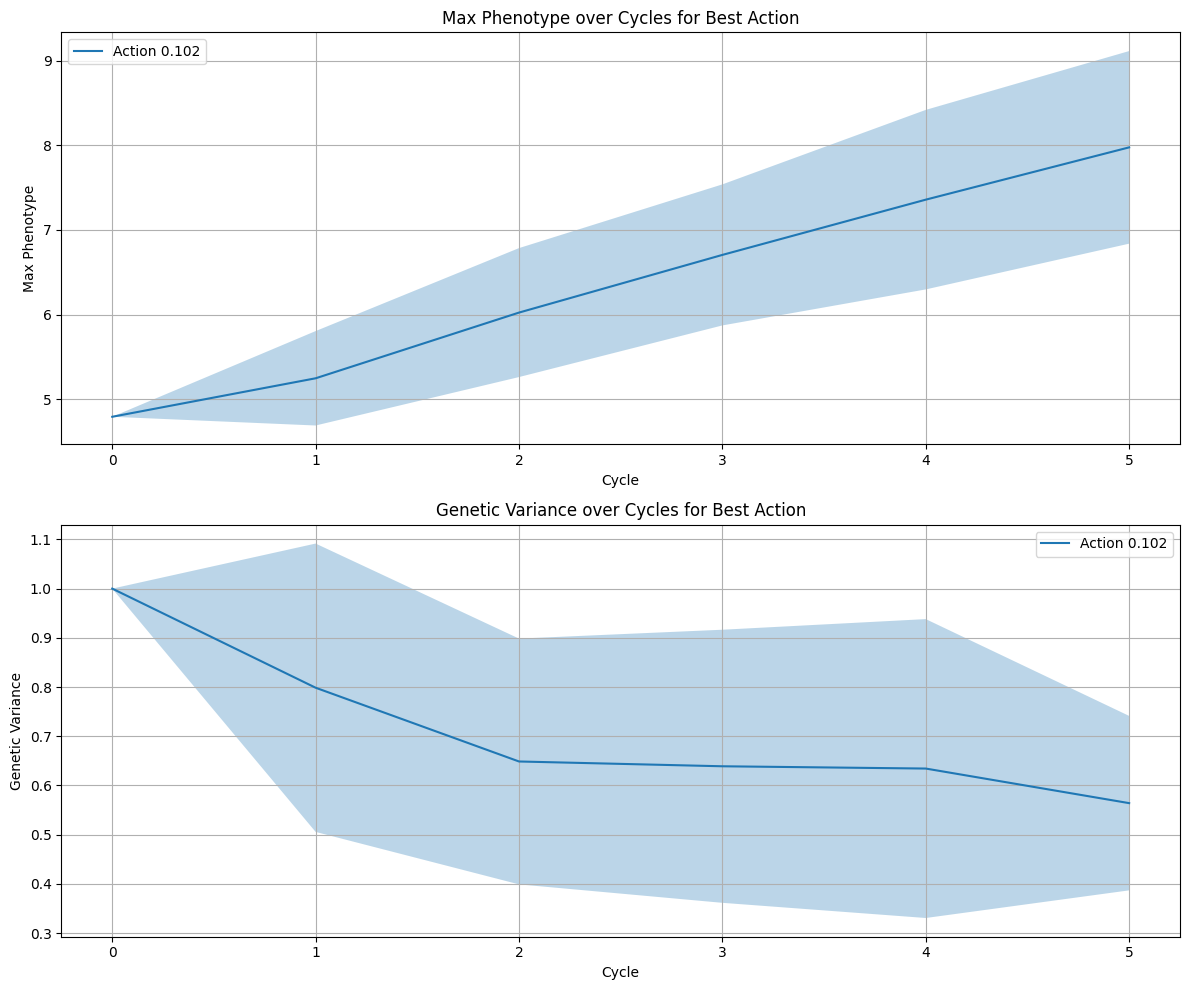

0 4.792213
1 5.246915
2 6.0231338
3 6.704549
4 7.357212
5 7.9750276


In [4]:

env = create_simulation(config)

    
# Usage remains the same
actions = np.linspace(-1, 1, 50)  # or however many actions you want to test
results, best_action, best_average = collect_baselines(env, actions, repetitions=10, cycles=config['end_gen'])

print(f"Best action: {best_action:.3f}")
print(f"Best average max phenotype in final generation: {best_average:.3f}")

# Plot the best run with both max phenotype and genetic variance
plot_best_run(results, best_action)

In [5]:
# FE = MultiScalarFeatureExtractor(env.observation_space)
# mock_observation = torch.tensor([[0.5,0.5,0.5,0.5,]], dtype=torch.float32)  # Single scalar input
# FE(mock_observation)

In [6]:
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from torch.utils.tensorboard import SummaryWriter
        
        
class ActionTrackingCallback(BaseCallback):
    def __init__(self, log_freq=100, verbose=0):
        super(ActionTrackingCallback, self).__init__(verbose)
        self.log_freq = log_freq
        self.episode_count = 0
        self.action_history = defaultdict(list)
        self.current_episode_actions = []
        self.step_count = 0
        self.writer = None

    def _on_training_start(self):
        self.writer = SummaryWriter(self.logger.dir)

    def _on_step(self) -> bool:
        self.step_count += 1
        info = self.locals['infos'][0]
        action = self.locals['actions'][0]
        current_generation = info['current_generation']
        max_generations = self.training_env.get_attr('max_generations')[0]

        normalized_action = info['normalized_action']

        self.current_episode_actions.append((current_generation, normalized_action))

        if self.locals['dones'][0]:
            self.episode_count += 1
            for gen, action in self.current_episode_actions:
                self.action_history[gen].append(action)
            self.current_episode_actions = []

            if self.episode_count % self.log_freq == 0:
                self._log_action_data(max_generations)

        return True

    def _log_action_data(self, max_generations):
        for gen in range(max_generations):
            if gen in self.action_history:
                avg_action = np.mean(self.action_history[gen])
                self.writer.add_scalar(f"average_actions/generation_{gen}", avg_action, self.step_count)
        
        self.action_history.clear()

    def on_training_end(self):
        max_generations = self.training_env.get_attr('max_generations')[0]
        self._log_action_data(max_generations)
        if self.writer:
            self.writer.close()

In [7]:
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from torch.utils.tensorboard import SummaryWriter

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0, log_interval=100, plot_interval=1000, window_size=100):
        super().__init__(verbose)
        self.log_interval = log_interval
        self.plot_interval = plot_interval
        self.window_size = window_size
        self.step_counter = 0
        self.generation_data = {}
        self.moving_avg_data = {}
        self.timesteps_history = []
        self.writer = None

    def _on_training_start(self):
        self.writer = SummaryWriter(self.logger.dir)

    def _on_step(self) -> bool:
        info = self.locals['infos'][0]
        current_generation = info['current_generation']
        
        if current_generation not in self.generation_data:
            self.generation_data[current_generation] = {
                'max_phenotypes': [],
                'genetic_variances': [],
                'timesteps': []
            }
            self.moving_avg_data[current_generation] = {
                'max_phenotypes': [],
                'genetic_variances': [],
                'timesteps': []
            }
        
        self.generation_data[current_generation]['max_phenotypes'].append(info['max_phenotype'])
        self.generation_data[current_generation]['genetic_variances'].append(info['genetic_variance'])
        self.generation_data[current_generation]['timesteps'].append(self.num_timesteps)
        
        self.step_counter += 1
        
        if self.step_counter % self.log_interval == 0:
            self._update_moving_averages()

        if self.step_counter % self.plot_interval == 0:
            self._log_to_tensorboard()
            
        if self.step_counter % self.plot_interval == 0:
            self._plot_data()

        return True

    def _update_moving_averages(self):
        for gen in self.generation_data:
            data = self.generation_data[gen]
            if len(data['max_phenotypes']) >= self.window_size:
                avg_phenotype = np.mean(data['max_phenotypes'][-self.window_size:])
                avg_variance = np.mean(data['genetic_variances'][-self.window_size:])
                avg_timestep = data['timesteps'][-1]
                
                self.moving_avg_data[gen]['max_phenotypes'].append(avg_phenotype)
                self.moving_avg_data[gen]['genetic_variances'].append(avg_variance)
                self.moving_avg_data[gen]['timesteps'].append(avg_timestep)

    def _plot_data(self):
        clear_output(wait=True)
        plt.figure(figsize=(12, 6))
        
        for gen in sorted(self.moving_avg_data.keys()):
            data = self.moving_avg_data[gen]
            plt.plot(data['timesteps'], data['max_phenotypes'], label=f'Gen {gen}')
        
        plt.xlabel('Timesteps')
        plt.ylabel('Max Phenotype (Moving Average)')
        plt.title('Max Phenotype by Generation')
        plt.legend()
        plt.grid(True)
        plt.show()

    def on_training_end(self):
        self._plot_data()  # Final plot at the end of training
        
    def _log_to_tensorboard(self):
        for gen in sorted(self.moving_avg_data.keys()):
            data = self.moving_avg_data[gen]
            for i, (timestep, max_phenotype, genetic_variance) in enumerate(zip(data['timesteps'], data['max_phenotypes'], data['genetic_variances'])):
                self.writer.add_scalar(f'Max_Phenotype/Gen_{gen}', max_phenotype, timestep)
                self.writer.add_scalar(f'Genetic_Variance/Gen_{gen}', genetic_variance, timestep)

    def on_training_end(self):
        self._log_to_tensorboard()
        if self.writer:
            self.writer.close()

In [8]:
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback
from torch.utils.tensorboard import SummaryWriter

class CustomCallback(BaseCallback):
    def __init__(self, verbose=0, log_interval=100, plot_interval=1000, window_size=100):
        super().__init__(verbose)
        self.log_interval = log_interval
        self.plot_interval = plot_interval
        self.window_size = window_size
        self.step_counter = 0
        self.generation_data = {}
        self.moving_avg_data = {}
        self.timesteps_history = []
        self.writer = None

    def _on_training_start(self):
        self.writer = SummaryWriter(self.logger.dir)

    def _on_step(self) -> bool:
        info = self.locals['infos'][0]
        current_generation = info['current_generation']
        action = self.locals['actions'][0].item()  # Get the action
        
        if current_generation not in self.generation_data:
            self.generation_data[current_generation] = {
                'max_phenotypes': [],
                'genetic_variances': [],
                'timesteps': [],
                'actions': []  # Add actions list
            }
            self.moving_avg_data[current_generation] = {
                'max_phenotypes': [],
                'genetic_variances': [],
                'timesteps': [],
                'actions': []  # Add actions list
            }
        
        self.generation_data[current_generation]['max_phenotypes'].append(info['max_phenotype'])
        self.generation_data[current_generation]['genetic_variances'].append(info['genetic_variance'])
        self.generation_data[current_generation]['timesteps'].append(self.num_timesteps)
        self.generation_data[current_generation]['actions'].append(scale_values(action,to_range=(env.action_low, env.action_high)))  # Store the action
        
        self.step_counter += 1
        
        if self.step_counter % self.log_interval == 0:
            self._update_moving_averages()

        if self.step_counter % self.plot_interval == 0:
            self._log_to_tensorboard()
            
        if self.step_counter % self.plot_interval == 0:
            self._plot_data()

        return True

    def _update_moving_averages(self):
        for gen in self.generation_data:
            data = self.generation_data[gen]
            if len(data['max_phenotypes']) >= self.window_size:
                avg_phenotype = np.mean(data['max_phenotypes'][-self.window_size:])
                avg_variance = np.mean(data['genetic_variances'][-self.window_size:])
                avg_timestep = data['timesteps'][-1]
                avg_action = np.mean(data['actions'][-self.window_size:])  # Calculate average action
                
                self.moving_avg_data[gen]['max_phenotypes'].append(avg_phenotype)
                self.moving_avg_data[gen]['genetic_variances'].append(avg_variance)
                self.moving_avg_data[gen]['timesteps'].append(avg_timestep)
                self.moving_avg_data[gen]['actions'].append(avg_action)  # Store average action

    def _log_to_tensorboard(self):
        for gen in sorted(self.moving_avg_data.keys()):
            data = self.moving_avg_data[gen]
            for i, (timestep, max_phenotype, genetic_variance, action) in enumerate(zip(
                data['timesteps'], data['max_phenotypes'], data['genetic_variances'], data['actions']
            )):
                self.writer.add_scalar(f'Max_Phenotype/Gen_{gen}', max_phenotype, timestep)
                self.writer.add_scalar(f'Genetic_Variance/Gen_{gen}', genetic_variance, timestep)
                self.writer.add_scalar(f'Action/Gen_{gen}', action, timestep)  # Log the action

        

    def _plot_data(self):
        clear_output(wait=True)
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

        for gen in sorted(self.moving_avg_data.keys()):
            data = self.moving_avg_data[gen]
            ax1.plot(data['timesteps'], data['max_phenotypes'], label=f'Gen {gen}')
            ax2.plot(data['timesteps'], data['genetic_variances'], label=f'Gen {gen}')
            ax3.plot(data['timesteps'], data['actions'], label=f'Gen {gen}')

        ax1.set_xlabel('Timesteps')
        ax1.set_ylabel('Max Phenotype (Moving Average)')
        ax1.set_title('Max Phenotype by Generation')
        ax1.legend()
        ax1.grid(True)

        ax2.set_xlabel('Timesteps')
        ax2.set_ylabel('Genetic Variance (Moving Average)')
        ax2.set_title('Genetic Variance by Generation')
        ax2.legend()
        ax2.grid(True)

        ax3.set_xlabel('Timesteps')
        ax3.set_ylabel('Action (Moving Average)')
        ax3.set_title('Average Action by Generation')
        ax3.legend()
        ax3.grid(True)

        plt.tight_layout()
        plt.show()

    def on_training_end(self):
        self._log_to_tensorboard()
        if self.writer:
            self.writer.close()

In [9]:
import numpy as np
from stable_baselines3.common.callbacks import BaseCallback

class CurriculumCallback(BaseCallback):
    def __init__(self, start_gen, end_gen, curriculum_steps, verbose=0):
        super(CurriculumCallback, self).__init__(verbose)
        self.start_gen = start_gen
        self.end_gen = end_gen + 1
        self.curriculum_steps = curriculum_steps
        self.current_max_gen = start_gen

    def _on_step(self) -> bool:
        progress = min(1.0, self.n_calls / self.curriculum_steps)
        new_max_gen = int(self.start_gen + progress * (self.end_gen - self.start_gen))
        
        if new_max_gen > self.current_max_gen:
            self.current_max_gen = new_max_gen
            self.training_env.env_method("update_max_generations", new_max_gen)
            
            if self.verbose > 0:
                print(f"Updating max_generations to {new_max_gen}")
        
        return True

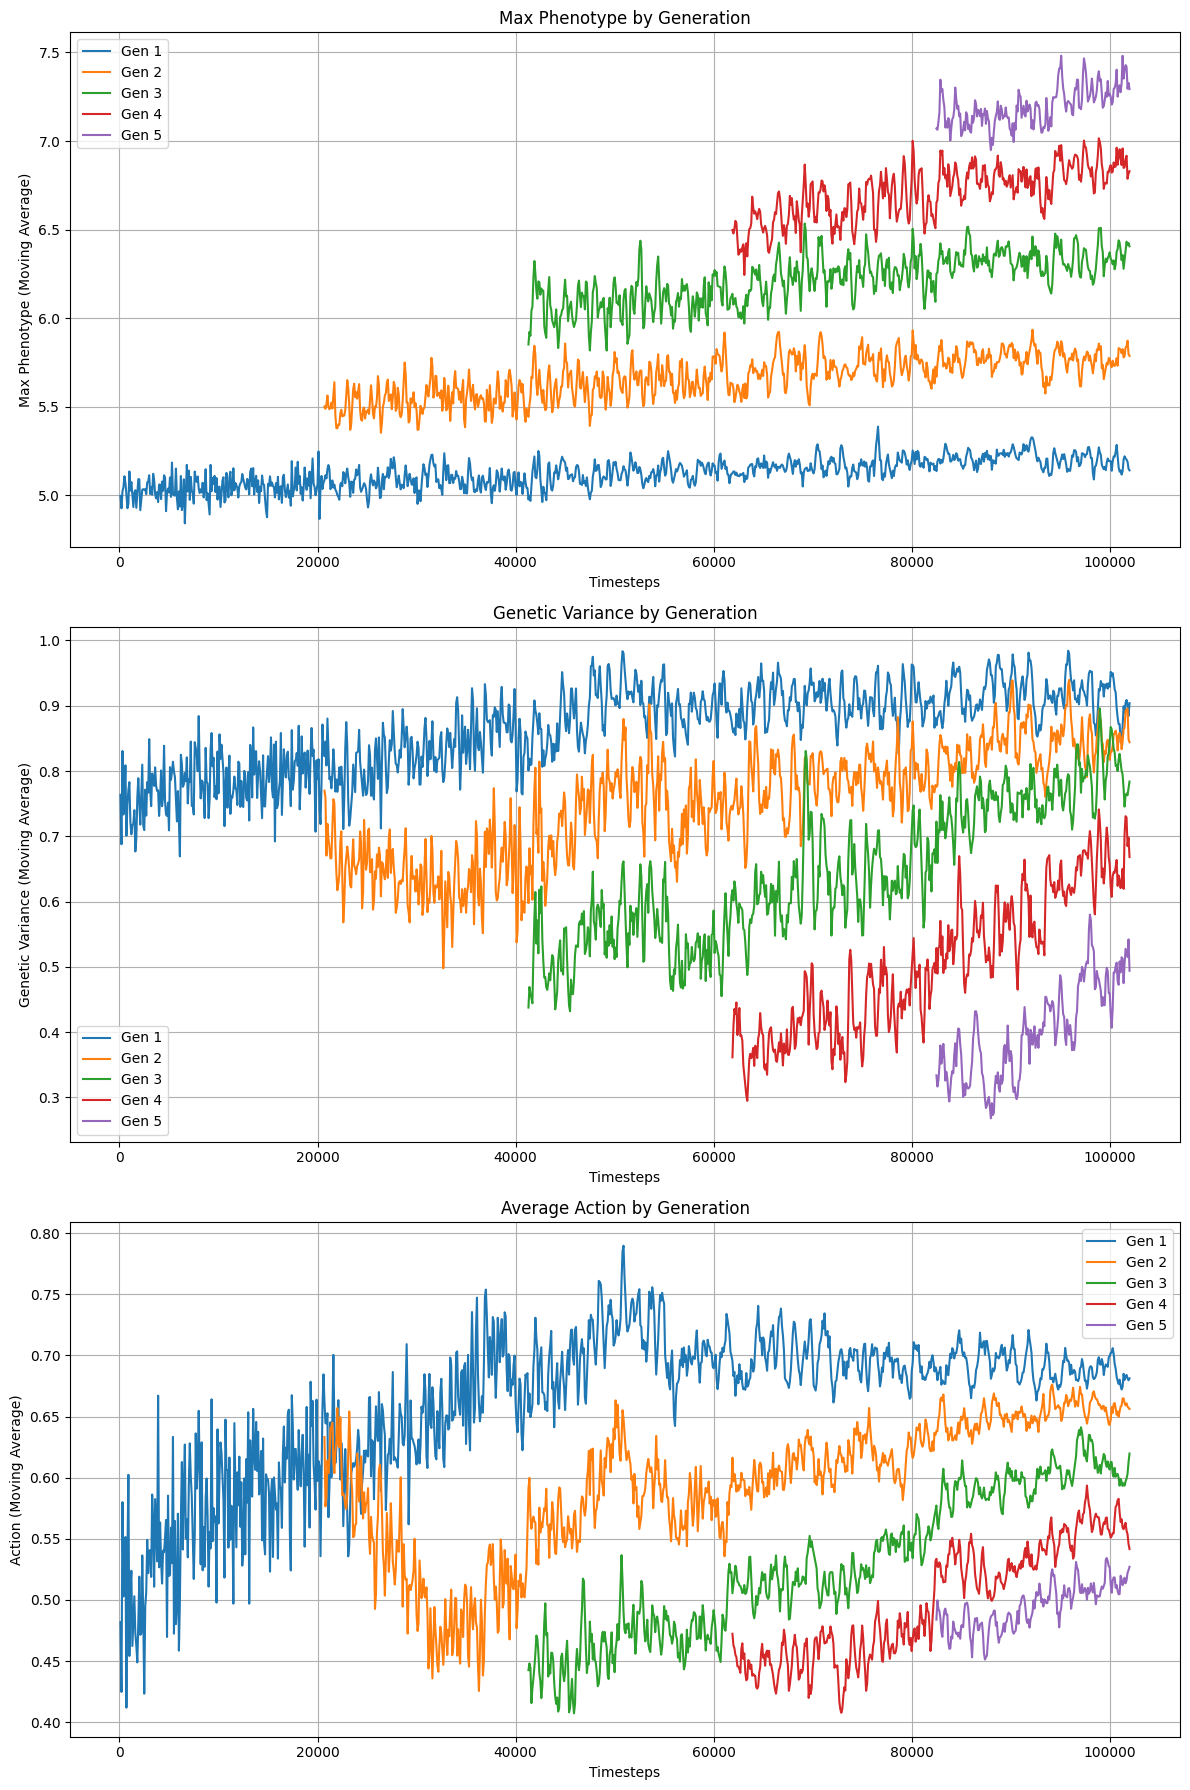

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5           |
|    ep_rew_mean          | 7.31        |
| time/                   |             |
|    fps                  | 197         |
|    iterations           | 50          |
|    time_elapsed         | 517         |
|    total_timesteps      | 102400      |
| train/                  |             |
|    approx_kl            | 0.009137545 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | 0.425       |
|    explained_variance   | 0.304       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.354       |
|    n_updates            | 490         |
|    policy_gradient_loss | -0.00411    |
|    std                  | 0.155       |
|    value_loss           | 0.618       |
-----------------------------------------


In [10]:
from collections import defaultdict
from stable_baselines3.common.callbacks import CallbackList
model = PPO(
    MultiScalarPolicy,
    env,
    verbose=1,
    tensorboard_log='../dev_nbs/ppotb'
)


# model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

# Create your custom callbacks
custom_cb = CustomCallback()
gen_cb = CurriculumCallback(config['start_gen'], config['end_gen'], config['total_timesteps'])
cbs = CallbackList([custom_cb,gen_cb]) 

# Combine the callbacks using CallbackList
model.learn(total_timesteps=config['total_timesteps'], callback=cbs)

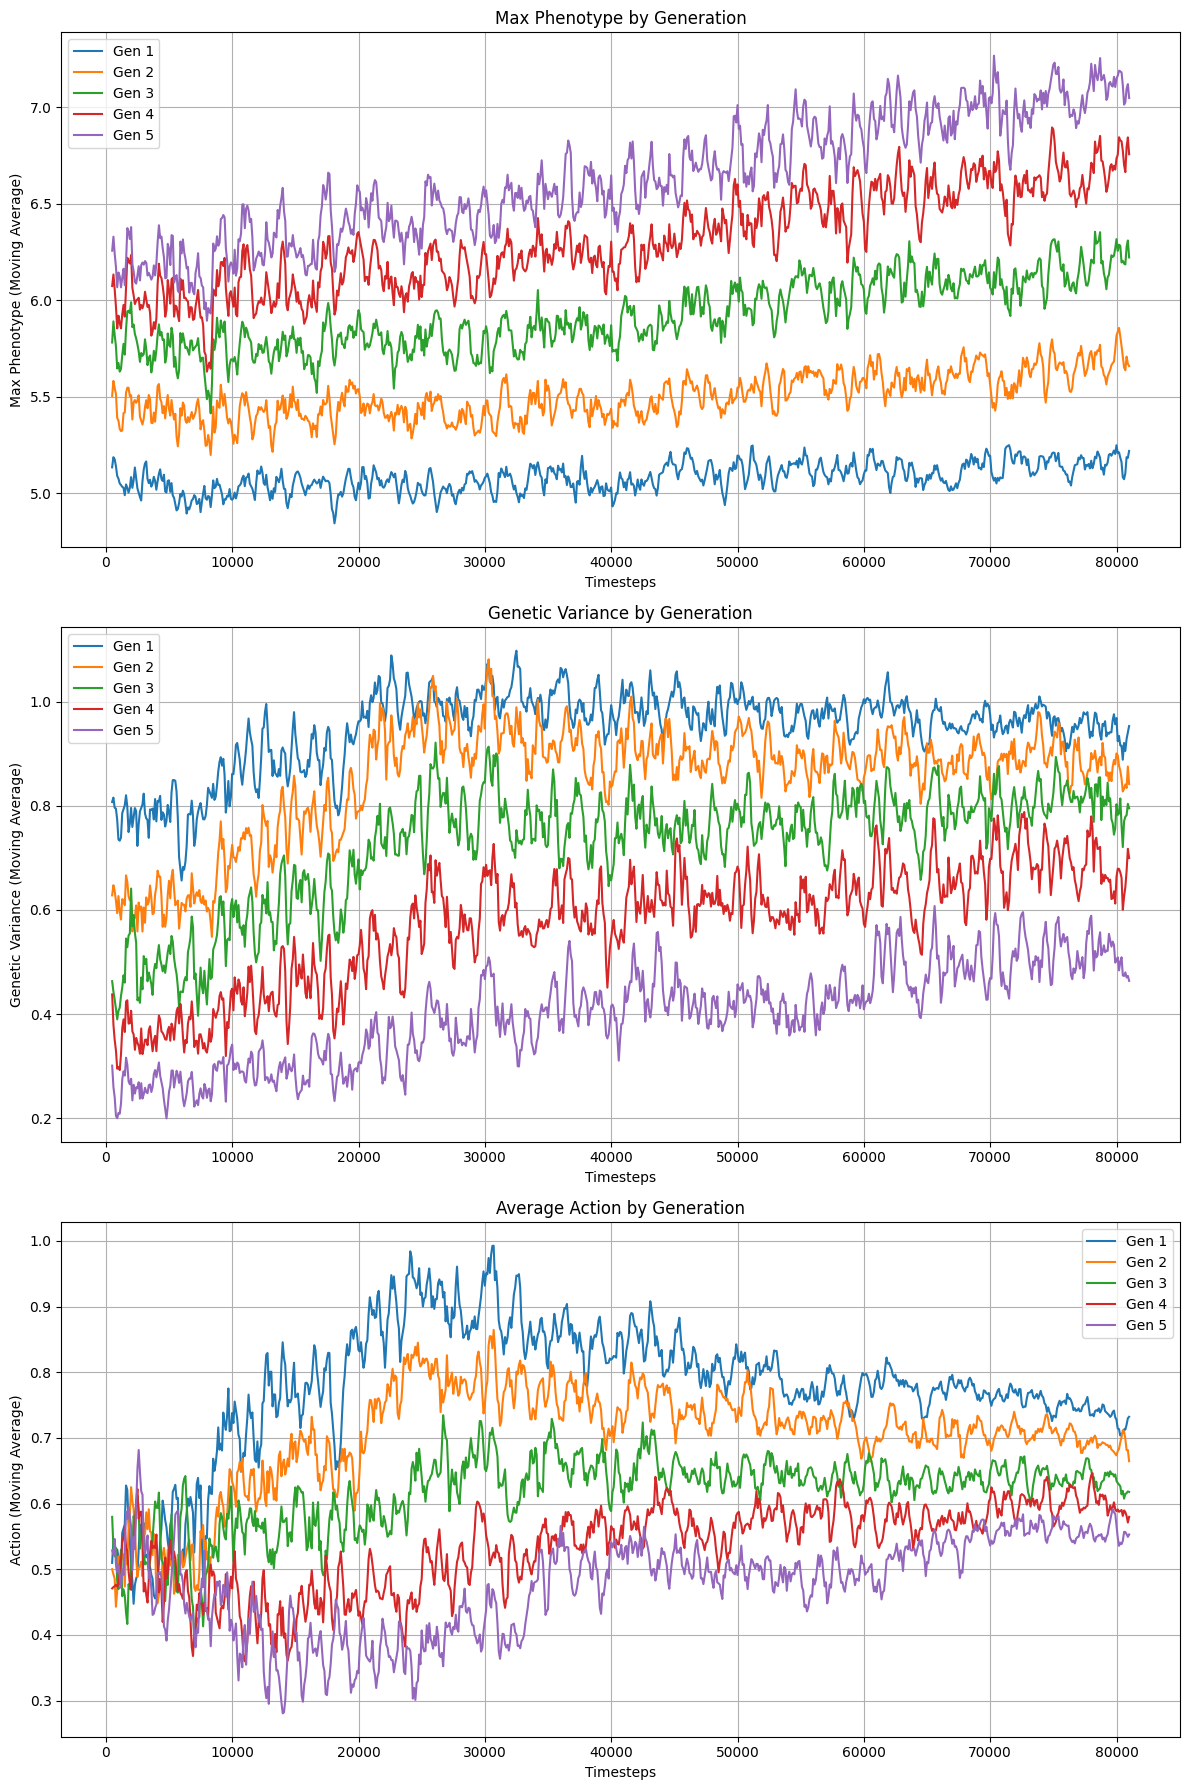

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 5          |
|    ep_rew_mean          | 7.15       |
| time/                   |            |
|    fps                  | 75         |
|    iterations           | 40         |
|    time_elapsed         | 1080       |
|    total_timesteps      | 81920      |
| train/                  |            |
|    approx_kl            | 0.00862027 |
|    clip_fraction        | 0.0688     |
|    clip_range           | 0.2        |
|    entropy_loss         | 0.0743     |
|    explained_variance   | 0.342      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.262      |
|    n_updates            | 390        |
|    policy_gradient_loss | -0.00342   |
|    std                  | 0.22       |
|    value_loss           | 0.584      |
----------------------------------------


KeyboardInterrupt: 

In [11]:
from collections import defaultdict
from stable_baselines3.common.callbacks import CallbackList
model = PPO(
    MultiScalarPolicy,
    env,
    verbose=1,
    gae_lambda=.90,
    tensorboard_log='../dev_nbs/ppotb'
)


# model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

# Create your custom callbacks
custom_cb = CustomCallback()
gen_cb = CurriculumCallback(config['start_gen'], config['end_gen'], config['total_timesteps'],)
cbs = CallbackList([custom_cb]) 

# Combine the callbacks using CallbackList
model.learn(total_timesteps=config['total_timesteps'], callback=cbs)

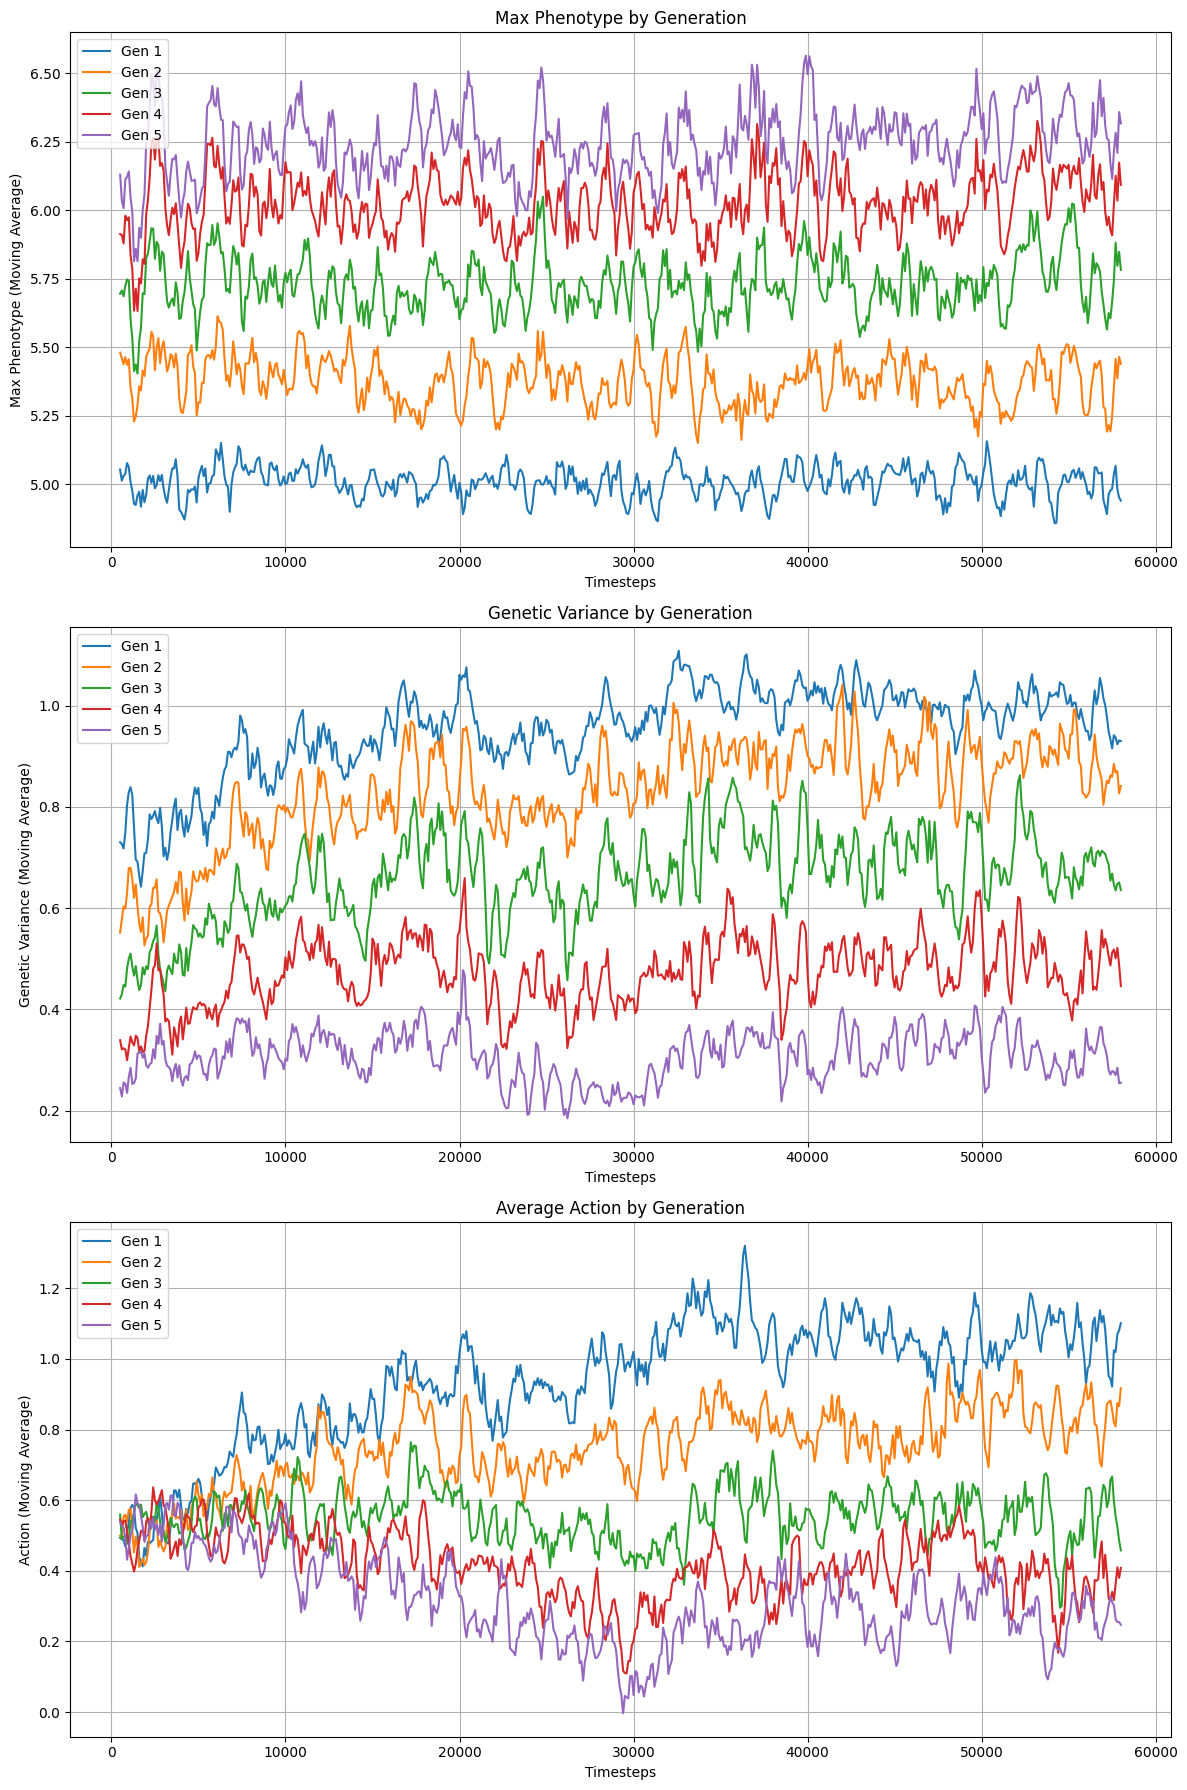

KeyboardInterrupt: 

In [16]:
from collections import defaultdict
from stable_baselines3.common.callbacks import CallbackList
model = PPO(
    MultiScalarPolicy,
    env,
    verbose=1,
    ent_coef=.1,
    tensorboard_log='../dev_nbs/ppotb')


# model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=config['total_timesteps'], callback=combined_callbacks)

# Create your custom callbacks
custom_cb = CustomCallback()
gen_cb = CurriculumCallback(config['start_gen'], config['end_gen'], config['total_timesteps'],)
cbs = CallbackList([custom_cb]) 

# Combine the callbacks using CallbackList

model.learn(total_timesteps=config['total_timesteps'], callback=cbs)